In [118]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

In [119]:
df = pd.read_excel("AI_CHIR_DIG_FINAL.xlsx", sheet_name="Second cleanup", skiprows=2)
df = df.replace('-', np.nan).dropna(subset=['COMPLICATION'])  # garde les lignes avec complication
df = df.reset_index(drop=True)
df

,PT_NUM,NAME_OPERATION,AGE_SURGERY,SEX,FHX,FHX_1DEGREE,TOBACCO\n,BMI,PHX_ABDOMINAL_SURGERY,PHX_PULM,...,INVOLVEMENT_DISTAL.MARGIN,SAFETY.MARGIN_PROXIMAL,SAFETY.MARGIN_DISTAL,INVASION_PERINEURAL,INVASION_VASC,INVASION_LYMPH,PATH_TUMOR.PERFORATION,SUPP_N0_N+,NUM_LN_ALL,NUM_LN_POS
0,1,"Colectomy, partial: with colpoproctostomy (low...",61,2.0,1,1.0,2.0,16.23,2.0,1,...,1,19.0,1.0,2.0,1.0,1.0,2.0,N0,19,0.0
1,2,"Colectomy, partial: with colpoproctostomy (low...",70,1.0,1,1.0,1.0,27.68,1.0,1,...,1,14.2,0.5,2.0,1.0,1.0,1.0,N1a,23,1.0
2,3,"Colectomy, total or subtotal, with proctectomy...",39,1.0,1,1.0,2.0,20.23,1.0,2,...,1,13.0,2.8,1.0,1.0,1.0,1.0,N1a,40,1.0
3,4,"44146: Colectomy, partial: with colpoproctosto...",38,1.0,2,1.0,2.0,20.30,1.0,2,...,1,14.0,16.0,2.0,2.0,1.0,1.0,NaN,25,6.0
4,5,"44146: Colectomy, partial: with colpoproctosto...",25,2.0,1,1.0,1.0,17.30,2.0,1,...,2,NaN,NaN,1.0,1.0,1.0,1.0,N1b,35,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,224,"Colectomy, partial: with anastomosis or skin l...",73,1.0,1,1.0,1.0,NaN,1.0,1,...,1,5.0,11.5,1.0,2.0,2.0,1.0,N0,32,0.0
223,225,"Colectomy, partial: with anastomosis or skin l...",55,1.0,1,1.0,2.0,25.73,1.0,2,...,1,9.0,10.0,1.0,2.0,1.0,1.0,N0,32,0.0
224,226,"Colectomy, partial: with anastomosis or skin l...",58,1.0,1,NaN,2.0,21.60,1.0,2,...,1,5.8,16.5,1.0,2.0,1.0,1.0,N0,51,0.0
225,227,"Colectomy, partial: with anastomosis or skin l...",82,1.0,1,1.0,2.0,NaN,2.0,2,...,1,6.5,18.0,2.0,1.0,2.0,1.0,N0,30,0.0


In [120]:
input_cols = ['AGE_SURGERY', 'SEX', 'PHX_CVD', 'RTX_PREOP', 'BMI']
target_col = 'COMPLICATION'

for col in input_cols + [target_col]:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=input_cols + [target_col]).reset_index(drop=True)

print(f"Nombre de lignes après nettoyage : {len(df)}")
print((df[input_cols + [target_col]] == '-').sum())

Nombre de lignes après nettoyage : 210
AGE_SURGERY     0
SEX             0
PHX_CVD         0
RTX_PREOP       0
BMI             0
COMPLICATION    0
dtype: int64


In [121]:
X = df[input_cols]
y = df[target_col].astype(int)  # S'assurer que c'est des entiers

# Appliquer SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

In [122]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced'),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
    "SVM (RBF)": SVC(kernel='rbf', class_weight='balanced'),
}

results = []

for name, model in models.items():
    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
    rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    results.append((name, acc, prec, rec, f1, cm))

# Trier par F1 Score
results.sort(key=lambda x: x[4], reverse=True)

# Affichage
for name, acc, prec, rec, f1, cm in results:
    print(f"🔍 Model: {name}")
    print(f"✅ Accuracy: {acc:.2f}")
    print(f"🎯 Precision (macro): {prec:.2f}")
    print(f"📈 Recall (macro): {rec:.2f}")
    print(f"📊 F1 Score (macro): {f1:.2f}")
    print(f"📉 Confusion Matrix:\n{cm}")
    print("-" * 50)


🔍 Model: Random Forest
✅ Accuracy: 0.71
🎯 Precision (macro): 0.72
📈 Recall (macro): 0.72
📊 F1 Score (macro): 0.71
📉 Confusion Matrix:
[[21  5]
 [12 21]]
--------------------------------------------------
🔍 Model: Gradient Boosting
✅ Accuracy: 0.68
🎯 Precision (macro): 0.68
📈 Recall (macro): 0.68
📊 F1 Score (macro): 0.68
📉 Confusion Matrix:
[[19  7]
 [12 21]]
--------------------------------------------------
🔍 Model: Decision Tree
✅ Accuracy: 0.64
🎯 Precision (macro): 0.67
📈 Recall (macro): 0.66
📊 F1 Score (macro): 0.64
📉 Confusion Matrix:
[[21  5]
 [16 17]]
--------------------------------------------------
🔍 Model: SVM (RBF)
✅ Accuracy: 0.59
🎯 Precision (macro): 0.59
📈 Recall (macro): 0.59
📊 F1 Score (macro): 0.59
📉 Confusion Matrix:
[[15 11]
 [13 20]]
--------------------------------------------------
🔍 Model: Logistic Regression
✅ Accuracy: 0.53
🎯 Precision (macro): 0.52
📈 Recall (macro): 0.52
📊 F1 Score (macro): 0.52
📉 Confusion Matrix:
[[13 13]
 [15 18]]
-------------------------

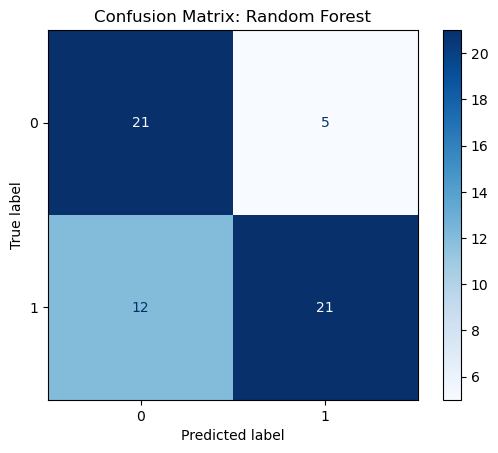

In [123]:
best_model = results[0]
ConfusionMatrixDisplay(best_model[5]).plot(cmap="Blues")
plt.title(f"Confusion Matrix: {best_model[0]}")
plt.show()

In [124]:
df['COMPLICATION'].value_counts()


COMPLICATION
1.0    146
2.0     64
Name: count, dtype: int64

In [125]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=["No Complication", "Complication"]))


                 precision    recall  f1-score   support

No Complication       0.54      0.58      0.56        26
   Complication       0.65      0.61      0.62        33

       accuracy                           0.59        59
      macro avg       0.59      0.59      0.59        59
   weighted avg       0.60      0.59      0.59        59

